In [1]:
import pandas as pd
import numpy as np
import requests
import os
import cv2 as cv
import matplotlib.pyplot as plt

import torch

In [20]:
import random
colors = {
 0  :(0, 0, 0),
1  :(255, 0, 0),

2  :(255, 165, 0),

3  :(255, 255, 0),

4  :(0, 255, 0),

5  :(0, 128, 128),

6  :(0, 0, 255),

7  :(75, 0, 130),

8  :(148, 0, 211),

9  :(255, 0, 255),

10  :(255, 192, 203),

11 :(139, 69, 19),

12 :(128, 128, 128),
13 :(25, 205, 55),

14 :(255, 215, 0),

15 :(192, 192, 192),

16 :(192, 12, 18)

}

In [21]:
def getSpectralTensor(x,y,im):
    """
    x: abscissa of the pixel of interest
    y: ordinate of the pixel of interest
    im: the image in torch form ; (C,W,H)    

    Returns the spectral vector of the pixel of interest i.e. The values of the pixel in each band of the multispectral image
    """

    return im[:,x,y].type(torch.float)

In [22]:
def getPatches(x,y,im,plen):
    
    """
    x: abscissa of the pixel of interest
    y: ordinate of the pixel of interest
    im: the image in torch form ; (C,W,H)
    plen: lenght of the patch

    Extracts a pixel of interest- centred patch with 0 padding in the edge cases.
    """
        
    center = plen//2
    p = torch.zeros((im.shape[0],plen,plen))

    p[:,center,center] = im[:,x,y]

    lineStart = x - (plen-1)//2
    lineEnd = lineStart + (plen-1)

    columnStart = y - (plen-1)//2
    columnEnd = columnStart + (plen-1)
    
    imLines, imCols = im.shape[1],im.shape[2]
    
        
    if (lineStart >= 0 and lineEnd< imLines ) and  \
       (columnStart>= 0 and columnEnd < imCols):
        return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)

    
    if lineStart < 0 and columnStart <0:             
#         print(f"here1| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:     
#             print(f"here1.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,0:columnEnd+1]        
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here1.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),abs(columnStart):] = im[:,0:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here1.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,0:columnEnd+1]
            
        else:
#             print(f"here1.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,abs(columnStart):] = im[:,0:lineEnd+1,0:columnEnd+1]
            
            

    elif lineStart < 0 and columnStart >= 0:    
#         print(f"here2| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:     
#             print(f"here2.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),0:plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:        
#             print(f"here2.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):plen-(lineEnd-(imLines-1)),0:] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here2.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,0:plen-(columnEnd-(imCols-1))] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            
        else:
#             print(f"here2.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,abs(lineStart):,0:] = im[:,0:lineEnd+1,columnStart:columnEnd+1]
            


    elif lineStart >= 0 and columnStart < 0:
#         print(f"here3| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:
#             print(f"here3.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here3.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),abs(columnStart):] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here3.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,abs(columnStart):plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
        else:
#             print(f"here3.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,abs(columnStart):] = im[:,lineStart:lineEnd+1,0:columnEnd+1]
            
            
            
    else:
#         print(f"here4| lineStart: {lineStart} | columnStart: {columnStart}")    
        if lineEnd>=imLines and columnEnd >=imCols:
#             print(f"here4.1| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),0:plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd>=imLines and columnEnd < imCols:
#             print(f"here4.2| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:plen-(lineEnd-(imLines-1)),:] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        elif lineEnd<imLines and columnEnd >= imCols:
#             print(f"here4.3| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,0:plen-(columnEnd-(imCols-1))] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
        else:
#             print(f"here4.4| lineEnd: {lineEnd} | columnEnd: {columnEnd}")
            p[:,0:,0:] = im[:,lineStart:lineEnd+1,columnStart:columnEnd+1]
            
#     plt.imshow(p.permute(1,2,0))
    return p

In [23]:
# from torchvision import transforms

# normalize = transforms.Normalize(mean=[0.5 for _ in range(204)], std=[0.5 for _ in range(204)])


In [24]:
import torch.nn as nn


class MSIClassSpecSpat(nn.Module):
    
    def __init__(self, image, in_channels):
        super().__init__()
        
        self.image = image.to(device).permute(2,0,1).type(torch.float)
        
                
        # spectral
        
        
        self.Conv1d_1 = nn.Conv1d(1,20,16)
        self.Conv1d_2 = nn.Conv1d(20,9,16)
        self.MaxPool1d = nn.MaxPool1d(5)
        
        
        # spatial
        
        self.Conv2d_1 = nn.Conv2d(in_channels, 30,(3,3))
        self.Conv2d_2 = nn.Conv2d(30, 4,(3,3))        
        self.MaxPool2d = nn.MaxPool2d((2,2))
        
        # FC
        
        self.FC1 = nn.Linear(394,394)
        self.FC2 = nn.Linear(394,17)
        
        self.softmax = nn.Softmax()
        
    
    def forward(self,x,y):
#         sT = getSpectralTensor(x,y,self.image)        
#         p = makeAPatch(x,y,self.image,21)        
        
#         rSpectral = self.Conv1d_2(self.MaxPool1d(self.Conv1d_1(sT.reshape(1,204))))
        
#         rSpatial = self.Conv2d_2(self.MaxPool2d(self.Conv2d_1(torch.permute(p,(2,0,1)).to(device))))
#         SpatialSpectral = torch.concat((rSpectral.flatten(), rSpatial.flatten()))
        
        #return self.FC2(self.FC1(SpatialSpectral))
    
        return self.FC2(self.FC1(torch.concat((self.Conv1d_2(self.MaxPool1d(self.Conv1d_1(getSpectralTensor(x,y,self.image).reshape(1,204)))).flatten(), self.Conv2d_2(self.MaxPool2d(self.Conv2d_1(getPatches(x,y,self.image,21).to(device)))).flatten()))))
        
                

In [25]:
# torch.nn.functional.softmax(mtest(0,0))

In [26]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [27]:
# original data is in matlab format so transform it to python
import scipy.io as sio
mat_fname  = "/kaggle/input/salinas/Salinas_corrected.mat" # path to the matlab format image
salinas_corrected = sio.loadmat(mat_fname)

mat_fname2  = "/kaggle/input/salinas/Salinas_gt.mat" # path to the matlab format ground truth labels
salinas_gt = sio.loadmat(mat_fname2)

In [28]:
salinas_data = torch.tensor(salinas_corrected['salinas_corrected'])

In [29]:
salinas_gt_data = torch.tensor(salinas_gt["salinas_gt"])

In [30]:
# classes present in the ground truth
salinas_gt_data.unique()

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
       dtype=torch.uint8)

In [31]:
# import random


# def getTrainingData(gt):
#     training = []
    
#     xys= [] 
    
#     while(len(training) < 0.30*len(gt.flatten())):
#         irand = int(random.random()*gt.shape[0])
#         jrand = int(random.random()*gt.shape[1])
        
#         if not (irand,jrand) in xys:
#             xys.append((irand,jrand))
#             training.append((irand,jrand,gt[irand,jrand]))
#         else:
#             continue
    
#     return training
                
            
# train =   getTrainingData(salinas_gt_data)

In [32]:
import random


def getTrainingDataEachClass(gt):
    training = []
    
    
    xys= [] 
    
    for cla in gt.unique():                 
        ttmp = []
        
        #dont forget to make the hard coded percentage value a parameter !
        while(len(ttmp) < 0.15*len(gt[gt==cla].flatten())):
            irand = int(random.random()*gt.shape[0])
            jrand = int(random.random()*gt.shape[1])
        
            if not (irand,jrand) in xys:                
                xys.append((irand,jrand))
                ttmp.append((irand,jrand,gt[irand,jrand]))
            else:
                continue
        
        training += ttmp
        
    
    return training
                
            
train =   getTrainingDataEachClass(salinas_gt_data)

In [33]:
len(train), len(salinas_gt_data.flatten())

(16675, 111104)

In [34]:
# 204 is salinas_data.shape[2]; number of bands(channels)
model = MSIClassSpecSpat(salinas_data,204).to(device)

In [35]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.01)

**Fix The Loss !!!**

In [36]:
from sklearn.metrics import accuracy_score

epochs = 200


training_loss = []


for e in range(epochs):    
    preds = []
    labels = []
    for x,y,label in train:
        model.train()
        
        logits = model(x,y)        
#         print(logits)
#         print(label)
        
        yprime = torch.argmax(torch.nn.functional.softmax(logits))
        preds.append(yprime)
        labels.append(label)
        
        loss = loss_fn(logits, label.to(device))
        
        
        optimizer.zero_grad()
        
        
        loss.backward()
                
        
        optimizer.step()                
        
        
        training_loss.append(loss.item())
#         print(f" loss : {loss.item()} ")
    
    if( e % 3 == 0):
        print("epoch: ", str(e) ,"/", str(epochs))
        
        print(f" loss : {loss} ")
        print(f" accuracy : {accuracy_score([l.cpu() for l in labels], [p.cpu() for p in  preds])} ")
        
        


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  0 / 200
 loss : 788060.3125 
 accuracy : 0.4337031484257871 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  3 / 200
 loss : 14433.5 
 accuracy : 0.5098650674662669 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  6 / 200
 loss : -0.0 
 accuracy : 0.5319940029985007 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  9 / 200
 loss : -0.0 
 accuracy : 0.5806896551724138 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  12 / 200
 loss : -0.0 
 accuracy : 0.607256371814093 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  15 / 200
 loss : -0.0 
 accuracy : 0.6278260869565218 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  18 / 200
 loss : 19262112.0 
 accuracy : 0.655712143928036 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  21 / 200
 loss : -0.0 
 accuracy : 0.665007496251874 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  24 / 200
 loss : -0.0 
 accuracy : 0.6758620689655173 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  27 / 200
 loss : -0.0 
 accuracy : 0.7113643178410795 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  30 / 200
 loss : -0.0 
 accuracy : 0.7134032983508246 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  33 / 200
 loss : -0.0 
 accuracy : 0.7216791604197901 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  36 / 200
 loss : -0.0 
 accuracy : 0.7309745127436282 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  39 / 200
 loss : -0.0 
 accuracy : 0.7384107946026987 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  42 / 200
 loss : -0.0 
 accuracy : 0.7498050974512743 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  45 / 200
 loss : -0.0 
 accuracy : 0.7499250374812594 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  48 / 200
 loss : -0.0 
 accuracy : 0.7580209895052473 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  51 / 200
 loss : -0.0 
 accuracy : 0.7689355322338831 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  54 / 200
 loss : 23504256.0 
 accuracy : 0.7713943028485757 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  57 / 200
 loss : -0.0 
 accuracy : 0.7707346326836582 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  60 / 200
 loss : -0.0 
 accuracy : 0.7801499250374813 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  63 / 200
 loss : -0.0 
 accuracy : 0.7845877061469265 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  66 / 200
 loss : -0.0 
 accuracy : 0.7910044977511245 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  69 / 200
 loss : -0.0 
 accuracy : 0.7902248875562219 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  72 / 200
 loss : -0.0 
 accuracy : 0.7940629685157421 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  75 / 200
 loss : -0.0 
 accuracy : 0.8007796101949025 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  78 / 200
 loss : 158352640.0 
 accuracy : 0.8031184407796101 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  81 / 200
 loss : 167084544.0 
 accuracy : 0.8046776611694153 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  84 / 200
 loss : -0.0 
 accuracy : 0.8044977511244378 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  87 / 200
 loss : -0.0 
 accuracy : 0.8124137931034483 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  90 / 200
 loss : 200896256.0 
 accuracy : 0.8116341829085457 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  93 / 200
 loss : 29768192.0 
 accuracy : 0.8155322338830585 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  96 / 200
 loss : -0.0 
 accuracy : 0.8179910044977511 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  99 / 200
 loss : -0.0 
 accuracy : 0.8235082458770615 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  102 / 200
 loss : -0.0 
 accuracy : 0.8260269865067467 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  105 / 200
 loss : -0.0 
 accuracy : 0.8262668665667167 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  108 / 200
 loss : -0.0 
 accuracy : 0.8278860569715143 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  111 / 200
 loss : -0.0 
 accuracy : 0.8306446776611695 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  114 / 200
 loss : -0.0 
 accuracy : 0.8328035982008996 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  117 / 200
 loss : 238856192.0 
 accuracy : 0.8341829085457272 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  120 / 200
 loss : -0.0 
 accuracy : 0.8368215892053973 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  123 / 200
 loss : -0.0 
 accuracy : 0.839640179910045 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  126 / 200
 loss : -0.0 
 accuracy : 0.840599700149925 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  129 / 200
 loss : -0.0 
 accuracy : 0.8379010494752623 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  132 / 200
 loss : 41416192.0 
 accuracy : 0.8432983508245877 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  135 / 200
 loss : 288735232.0 
 accuracy : 0.8460569715142429 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  138 / 200
 loss : 164571136.0 
 accuracy : 0.8483958020989505 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  141 / 200
 loss : -0.0 
 accuracy : 0.8494752623688155 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  144 / 200
 loss : 195728896.0 
 accuracy : 0.8513343328335832 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  147 / 200
 loss : -0.0 
 accuracy : 0.8485157421289355 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  150 / 200
 loss : 450343936.0 
 accuracy : 0.8524737631184408 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  153 / 200
 loss : -0.0 
 accuracy : 0.856071964017991 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  156 / 200
 loss : 53773312.0 
 accuracy : 0.8589505247376312 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  159 / 200
 loss : 281715712.0 
 accuracy : 0.8576911544227886 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  162 / 200
 loss : 783698944.0 
 accuracy : 0.8620689655172413 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  165 / 200
 loss : -0.0 
 accuracy : 0.8582308845577211 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  168 / 200
 loss : -0.0 
 accuracy : 0.8666866566716641 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  171 / 200
 loss : 134776832.0 
 accuracy : 0.863928035982009 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  174 / 200
 loss : -0.0 
 accuracy : 0.8678260869565217 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  177 / 200
 loss : 300959744.0 
 accuracy : 0.8648275862068966 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  180 / 200
 loss : -0.0 
 accuracy : 0.8659670164917541 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  183 / 200
 loss : -0.0 
 accuracy : 0.8711244377811095 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  186 / 200
 loss : -0.0 
 accuracy : 0.871544227886057 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  189 / 200
 loss : 122992640.0 
 accuracy : 0.8691454272863568 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  192 / 200
 loss : 133602304.0 
 accuracy : 0.8735232383808096 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  195 / 200
 loss : -0.0 
 accuracy : 0.8745427286356822 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


epoch:  198 / 200
 loss : -0.0 
 accuracy : 0.8763418290854573 


/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)
/tmp/ipykernel_26/1178128612.py:19: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))


**All cases**

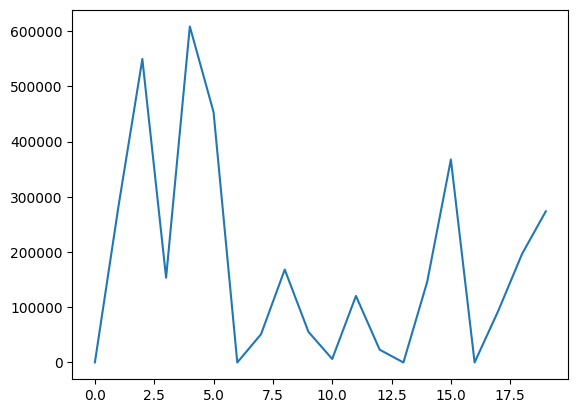

In [37]:
# Fix the loss !!
plt.plot([i for i in range(len(training_loss[:20]))], training_loss[:20])

In [38]:
im = torch.zeros_like(salinas_data)

In [39]:
with torch.inference_mode():
    for i in range(im.shape[0]):
        for j in range(im.shape[1]):            
            logits = model(i,j)                
            yprime = torch.argmax(torch.nn.functional.softmax(logits))
            
            im[i,j,0:3] = yprime

/tmp/ipykernel_26/708014705.py:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yprime = torch.argmax(torch.nn.functional.softmax(logits))
/tmp/ipykernel_26/333557774.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(im[:,lineStart:lineEnd+1,columnStart:columnEnd+1], dtype=torch.float)


In [40]:
im_gray = torch.clone(im[:,:,0])

In [41]:
for i in range(im.shape[0]):
    for j in range(im.shape[1]):
        im[i,j,0:3] = torch.tensor(colors[im[i,j,0].item()])        

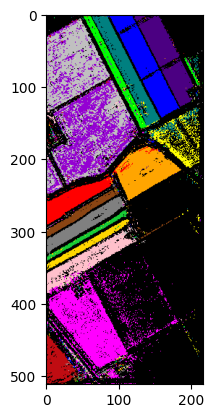

In [42]:
plt.imshow(im[:,:,0:3], cmap="Accent")

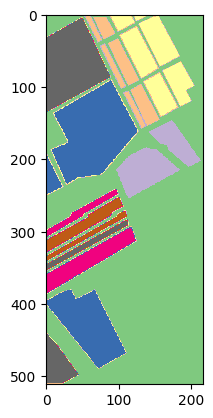

In [43]:
#How the ground truth looks like
plt.imshow(salinas_gt["salinas_gt"], cmap="Accent")

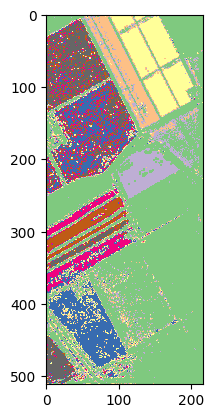

In [44]:
# what we got so far
plt.imshow(im_gray, cmap="Accent")

In [46]:
plt.imsave("Result_Image.jpg",im_gray, cmap="Accent")

In [47]:
torch.save(model.state_dict(), "ground_cover_model.cpt")